<a href="https://colab.research.google.com/github/pinoz33/DataMining/blob/main/SocialMinds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 PROGETTO: Analisi automatica dello stato mentale nei commenti social-Progetto Data Mining

 Studente: Antonio Ambrosio – Mat. 221424

 Corso di laurea triennale in Ingegneria Informatica – A.A. 2024/2025


Introduzione – Obiettivo del progetto

L’obiettivo del presente lavoro è individuare e classificare stati emotivi e problematiche
psicologiche come ansia, depressione, solitudine o stress presenti nei testi,
 allo scopo di comprendere come le interazioni con i contenuti suggeriti dagli algoritmi
 di raccomandazione possano influenzare il benessere psicologico degli utenti.

 Il dataset utilizzato è stato individuato sulla piattaforma Kaggle, che rende disponibili
 gratuitamente insiemi di dati di varia natura e tipologia.

 Fonte: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

INDICE DEL PROGETTO

1. Caricamento e Ispezione del Dataset

2. Esplorazione Preliminare dei Dati

    2.1 Frequenza e Distribuzione delle Etichette

    2.2 Esempi di Commenti Testuali

    2.3 Analisi della Lunghezza dei Testi

3. Preprocessing del Testo

    3.1 Pulizia del Testo (Minuscole, Rimozione Simboli, Punteggiatura e Stopwords)

4. Trasformazione Vettoriale (TF-IDF)

5. Suddivisione del Dataset in Training Set e Test Set

6. Addestramento dei Modelli di Classificazione

    6.1 Naive Bayes (MultinomialNB)

    6.2 Logistic Regression

    6.3 Support Vector Machine (SVM)

    6.4 Random Forest

7. Valutazione delle Performance dei Modelli

    7.1 Metriche di Valutazione: Accuracy, Precision, Recall, F1-score

    7.2 Confusion Matrix

8. Confronto tra i Modelli di Classificazione

    8.1 Visualizzazione e Interpretazione delle Metriche Comparative

9. Conclusioni e Riflessioni Finali

1. Caricamento e Ispezione del DataSet

 Ai fini del progetto, sono utilizzati gli strumenti messi a disposizione dalle librerie qui di seguito importate:

     -matplotlib: per le rappresentazioni sotto forma di grafico

     -sklearn: per realizzare i modelli, calcolare le metriche di valutazione, compiere operazioni di splitting e pre-processing sul dataset, e ottimizzare i parametri dei modelli

     -pandas: per la gestione dei dataset sotto forma di dataframe

     -seaborn: per potenziare gli strumenti visivi forniti da matplotlib

Segue, inoltre, la definizione di due funzioni utili alla rappresentazione delle metriche di classificazione.

In [ ]:
# pandas: per la gestione dei dati in formato tabellare (dataframe)
import pandas as pd

# matplotlib: per creare grafici e visualizzazioni
import matplotlib.pyplot as plt

# seaborn: per grafiche avanzate e più leggibili (es. heatmap)
import seaborn as sns

# sklearn: libreria per il machine learning
from sklearn.model_selection import train_test_split        # suddivisione training/test
from sklearn.feature_extraction.text import TfidfVectorizer # vettorizzazione dei testi
from sklearn.naive_bayes import MultinomialNB               # classificatore Naive Bayes
from sklearn.linear_model import LogisticRegression         # regressione logistica
from sklearn.svm import LinearSVC                           # support vector machine
from sklearn.ensemble import RandomForestClassifier         # random forest (opzionale)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Disattivo i warning (solo per rendere l’output più pulito)
import warnings
warnings.filterwarnings('ignore')

# Funzione per stampare le metriche principali di un classificatore
def stampa_metriche(y_true, y_pred, modello):
    """
    y_true: etichette reali
    y_pred: etichette predette dal modello
    modello: nome del modello (stringa, solo per stampa)

    Questa funzione stampa:
    - Accuracy
    - Precision
    - Recall
    - F1-Score
    - E il classification report completo
    """

    # Titolo con il nome del modello
    print(f"\n🔍 Risultati per: {modello}")

    # Calcolo e stampo l'accuracy (corrette/total)
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))

    # Calcolo la precision (quanto sono affidabili le predizioni positive)
    print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))

    # Calcolo il recall (quanto il modello trova i casi positivi reali)
    print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))

    # Calcolo l'F1-score (media armonica tra precision e recall)
    print("F1-Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))

    # Stampa il report completo per ogni classe (macro, micro, weighted)
    print("\nReport dettagliato:")
    print(classification_report(y_true, y_pred))


# Funzione per visualizzare graficamente la confusion matrix
def disegna_confusion_matrix(y_true, y_pred, classi, titolo="Confusion Matrix"):
    """
    y_true: etichette reali
    y_pred: etichette predette dal modello
    classi: lista delle classi (etichette uniche)
    titolo: titolo del grafico

    La funzione crea una confusion matrix e la visualizza con Seaborn.
    """

    # Calcolo la confusion matrix (tabella dei confronti tra classi reali e predette)
    cm = confusion_matrix(y_true, y_pred, labels=classi)

    # Creo una nuova figura con dimensioni 8x6
    plt.figure(figsize=(8, 6))

    # Creo una heatmap con annotazioni (numeri), colori in scala "Blues"
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classi, yticklabels=classi)

    # Imposto il titolo e le etichette degli assi
    plt.title(titolo)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')

    # Mostro il grafico
    plt.show()



2. Esplorazione Preliminare dei Dati

L'esplorazione preliminare dei dati (Exploratory Data Analysis - EDA) è una fase cruciale di ogni progetto di machine learning. Ha lo scopo di comprendere le caratteristiche principali di un dataset, individuare pattern, anomalie e relazioni tra le variabili. Questa fase ci aiuta a prendere decisioni informate riguardo al preprocessing e alla scelta dei modelli.

Per iniziare l'esplorazione, carichiamo il dataset Combined Data.csv in un DataFrame di Pandas e visualizziamo le sue prime righe, le informazioni generali e controlliamo la presenza di valori mancanti.

In [ ]:
# Caricamento del dataset
import pandas as pd # Aggiungo l'import di pandas

try:
    df = pd.read_csv('/Combined Data.csv')
    print("Dataset caricato con successo.")
except FileNotFoundError:
    print("Errore: Il file '/Combined Data.csv' non è stato trovato. Assicurati di aver caricato il file nella sessione di archiviazione.")
    df = None # Imposto df a None per evitare NameError successivi
    print("Si prega di caricare il file per procedere.")


if df is not None:
    print("\nNomi delle colonne nel dataset:")
    print(df.columns)

    # Visualizzazione delle prime 5 righe del dataset
    print("\nPrime 5 righe del dataset:")
    print(df.head())

    # Visualizzazione delle informazioni generali sul dataset (tipi di dati, valori non nulli)
    print("\nInformazioni generali sul dataset:")
    df.info()

    # Controllo dei valori mancanti per ogni colonna
    print("\nValori mancanti per colonna:")
    print(df.isnull().sum())

Dataset caricato con successo.

Nomi delle colonne nel dataset:
Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

Prime 5 righe del dataset:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

Informazioni generali sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB

Valori m

2.1 Frequenza e Distribuzione delle Etichette

In questa sezione, analizziamo la distribuzione delle etichette (le categorie di stato mentale) presenti nel nostro dataset. Comprendere la frequenza di ciascuna classe è fondamentale per identificare eventuali sbilanciamenti, che potrebbero influenzare le prestazioni dei modelli di classificazione e richiedere tecniche di gestione specifiche (ad esempio, oversampling o undersampling).


Frequenza delle etichette (stati mentali):
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


/tmp/ipython-input-4-2628094598.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


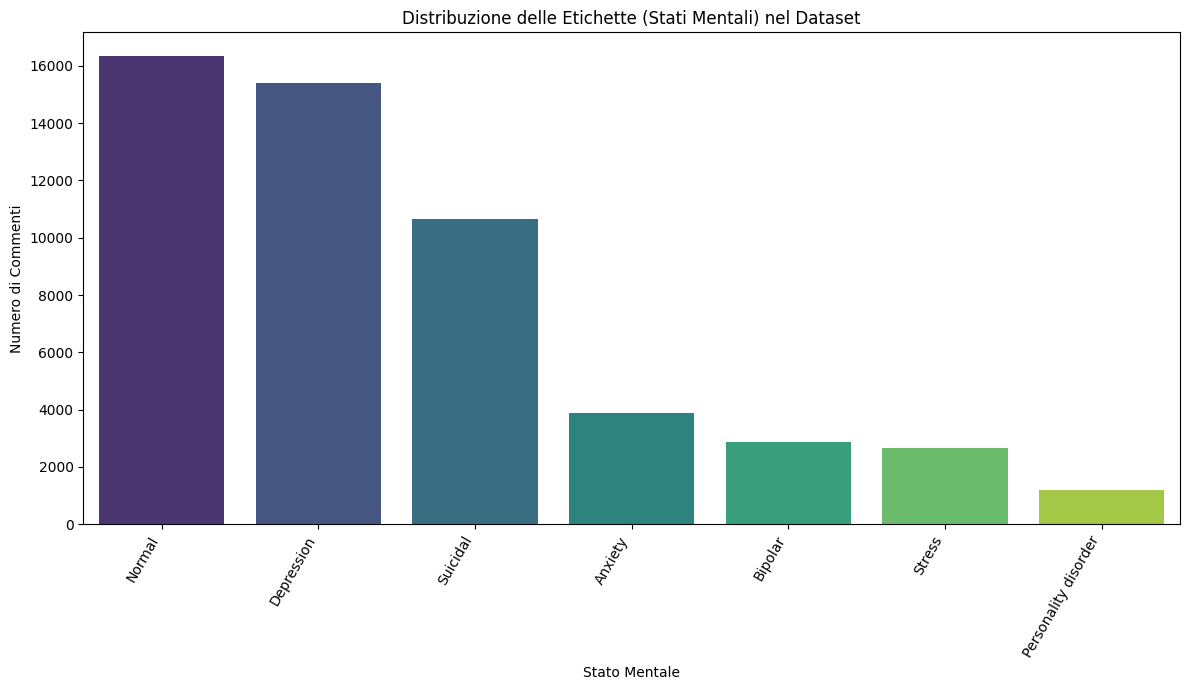

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\nFrequenza delle etichette (stati mentali):")
label_counts = df['status'].value_counts()
print(label_counts)

# Visualizzazione della distribuzione delle etichette
plt.figure(figsize=(12, 7)) # Aumento la dimensione per maggiore leggibilità
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribuzione delle Etichette (Stati Mentali) nel Dataset')
plt.xlabel('Stato Mentale')
plt.ylabel('Numero di Commenti')
plt.xticks(rotation=60, ha='right') # Ruota di più le etichette per testi lunghi
plt.tight_layout() # Adatto il layout per evitare sovrapposizioni
plt.show()

2.2 Esempi di Commenti Testuali

Per avere un'idea più concreta del contenuto del dataset, esaminiamo alcuni esempi di commenti per le etichette più frequenti. Questo ci permette di familiarizzare con il linguaggio, il tono e la tipologia di espressioni utilizzate dagli utenti, che verranno poi elaborate e classificate dai modelli.

In [ ]:
print("\nEsempi di commenti per alcune delle etichette più frequenti:")
# Prendo le 7 etichette più frequenti per mostrare esempi
top_labels_for_examples = label_counts.head(7).index
for label in top_labels_for_examples:
    # Prendo fino a 3 esempi casuali per ogni etichetta
    # Uso random_state per riproducibilità
    num_samples = min(3, len(df[df['status'] == label]))
    if num_samples > 0:
        examples = df[df['status'] == label]['statement'].sample(num_samples, random_state=42).tolist()
        print(f"\n--- Etichetta: {label} ---")
        for i, example in enumerate(examples):
            print(f"  Esempio {i+1}: {example}")
    else:
        print(f"\n--- Etichetta: {label} ---")
        print("  Nessun esempio trovato per questa etichetta (o etichetta con pochi campioni).")


Esempi di commenti per alcune delle etichette più frequenti:

--- Etichetta: Normal ---
  Esempio 1: Why do racers after the race immediately wear a hat??
  Esempio 2: Nugas together from time to time...SD-SMP: at a friend's house, at an internet cafe. High school: in a friend's room/room, in the lobby, in the outdoor area. Face-to-face lectures: on campus, boarding house, at a coffee shop. Distance learning era lecture: "Tell me, let's go on assignment, let me have a friend" then videocall.
  Esempio 3: Indihouse why the hell

--- Etichetta: Depression ---
  Esempio 1: I try so hard to be happy. For me, for my family for my friends. But I cannot. I am jealous of my friends being happy in their lives but I am also happy for them. I cannot even tell them how much I am suffering inside because everyone is getting their happiness except me. I am just done. it is not working out.
  Esempio 2: If you do not love someone or cannot promise to love them until you die then do not get into marr

2.3 Analisi della Lunghezza dei Testi

La lunghezza dei commenti può essere un indicatore importante della complessità del testo e può influenzare le scelte di pre-elaborazione (ad esempio, la gestione di testi molto lunghi o molto corti). In questa sezione, calcoliamo e visualizziamo la distribuzione della lunghezza dei testi.


Statistiche descrittive della lunghezza dei commenti:
count    53043.000000
mean       574.784816
std        844.707198
min          2.000000
25%         77.000000
50%        313.000000
75%        748.000000
max      32759.000000
Name: text_length, dtype: float64


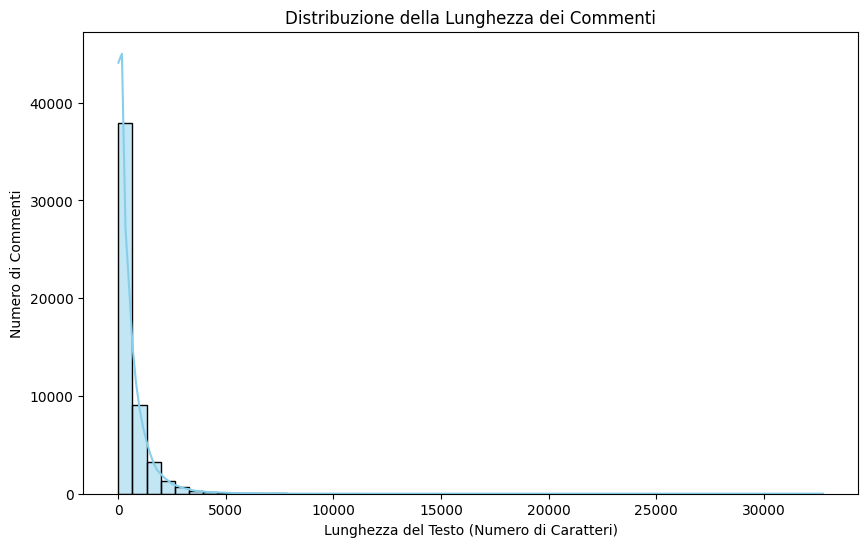


Esempio di commento più lungo (32759 caratteri):
I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Aggiungo l'import di pandas per sicurezza, anche se dovrebbe essere già disponibile

# Mi assicuro che la colonna con i testi ('statement') esista e che il DataFrame non sia vuoto
if df is not None and 'statement' in df.columns:
    # Calcolo della lunghezza di ogni commento e creazione di una nuova colonna 'text_length'
    # Gestisco i valori NaN nella colonna 'statement' convertendoli in stringhe vuote prima di calcolare la lunghezza
    df['text_length'] = df['statement'].apply(lambda x: len(str(x)))

    print("\nStatistiche descrittive della lunghezza dei commenti:")
    print(df['text_length'].describe())

    # Visualizzazione della distribuzione della lunghezza dei testi
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
    plt.title('Distribuzione della Lunghezza dei Commenti')
    plt.xlabel('Lunghezza del Testo (Numero di Caratteri)')
    plt.ylabel('Numero di Commenti')
    plt.show()

    # Stampa esempi di commenti estremi (più lungo e più corto)
    # Filtro per escludere i NaN che sono stati convertiti in stringhe vuote con lunghezza 0
    df_valid_statements = df.dropna(subset=['statement'])
    if not df_valid_statements.empty:
        print(f"\nEsempio di commento più lungo ({df_valid_statements['text_length'].max()} caratteri):")
        # Utilizza .loc con il text_column_name corretto
        print(df_valid_statements.loc[df_valid_statements['text_length'].idxmax()]['statement'])

        # Trovo il commento più corto tra quelli con lunghezza > 0
        df_non_empty_statements = df_valid_statements[df_valid_statements['text_length'] > 0]
        if not df_non_empty_statements.empty:
            print(f"\nEsempio di commento più corto ({df_non_empty_statements['text_length'].min()} caratteri):")
            # Utilizza .loc con il text_column_name corretto
            print(df_non_empty_statements.loc[df_non_empty_statements['text_length'].idxmin()]['statement'])
        else:
             print("\nNon ci sono commenti non vuoti per mostrare l'esempio più corto.")

    else:
        print("\nIl DataFrame non contiene statement validi, impossibile mostrare esempi di commenti estremi.")


    # Rimuovo la colonna 'text_length' se non serve per le fasi successive,
    # altrimenti la si può mantenere. Per pulizia, la rimuovo qui.
    df = df.drop(columns=['text_length'])
    print("\nColonna 'text_length' rimossa per la pulizia del DataFrame.")
else:
    print("Impossibile procedere: Il DataFrame non è stato caricato correttamente o la colonna 'statement' non esiste.")

3. Preprocessing del Testo

Il preprocessing del testo è un'operazione fondamentale per trasformare il testo grezzo in un formato che possa essere efficacemente utilizzato dai modelli di machine learning. I dati testuali estratti dai social media o da altre fonti online sono spesso rumorosi, contengono caratteri speciali, punteggiatura non necessaria, link, emoji, e parole che, sebbene comuni, aggiungono poco significato per la classificazione (le cosiddette "stopword").

3.1 Pulizia del Testo (Minuscole, Rimozione Simboli, Punteggiatura, Stopword)

Qui di seguito il codice per implementare le fasi di pulizia descritte. Creeremo una funzione riutilizzabile che applicherà tutte queste trasformazioni a ciascun commento nel dataset.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer # Potrebbero essere utili per stemming/lemmatization, ma iniziamo senza

# Scarico le stopwords di NLTK
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet') # Per la lemmatizzazione, se decidessi di usarla

# Carico le stopwords in inglese
stop_words = set(stopwords.words('english'))

# Funzione per la pulizia del testo
def pulisci_testo(text):
    """
    Applica una serie di operazioni di pulizia al testo:
    1. Converte il testo in minuscolo.
    2. Rimuove link (URL).
    3. Rimuove i caratteri non alfabetici (numeri e simboli, mantenendo solo lettere e spazi).
    4. Rimuove spazi bianchi multipli.
    5. Rimuove le stopwords.
    """
    # Converte NaN in stringa vuota per evitare AttributeError
    if pd.isna(text):
        text = ""

    # 1. Converto in minuscolo
    text = text.lower()

    # 2. Rimuovo link (URL)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Rimuovo i caratteri non alfabetici e numeri (mantieni solo lettere e spazi)
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Rimuovo spazi bianchi multipli
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Rimuovo le stopwords
    # Splitta il testo in parole, filtra le stopwords e ricongiungi
    text_words = text.split()
    text_words = [word for word in text_words if word not in stop_words]
    text = ' '.join(text_words)

    return text

# Applico la funzione di pulizia alla colonna 'statement' del tuo DataFrame
text_column_name = 'statement' # Correzione: usa il nome della colonna corretto

if text_column_name not in df.columns:
    print(f"Errore critico: La colonna '{text_column_name}' non esiste nel dataset. Impossibile pulire il testo.")
    # Non uscire, permetti di proseguire con df=None se necessario, ma stampa l'errore.
else:
    print(f"Inizio pulizia della colonna '{text_column_name}'...")
    df['cleaned_text'] = df[text_column_name].apply(pulisci_testo)
    print("Pulizia del testo completata.")

    # Visualizzo i primi commenti puliti e confrontali con gli originali
    print("\nConfronto tra testo originale e testo pulito (prime 5 righe):")
    # Mostra la colonna originale e quella pulita
    print(df[[text_column_name, 'cleaned_text']].head())

    #controllo la lunghezza media dei testi dopo la pulizia
    df['cleaned_text_length'] = df['cleaned_text'].apply(len)
    print("\nStatistiche descrittive della lunghezza dei commenti dopo la pulizia:")
    print(df['cleaned_text_length'].describe())

    # Rimuovo la colonna temporanea della lunghezza se non necessaria
    df.drop(columns=['cleaned_text_length'], inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Inizio pulizia della colonna 'statement'...
Pulizia del testo completata.

Confronto tra testo originale e testo pulito (prime 5 righe):
                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                        cleaned_text  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean  

Statistiche descrittive della lunghezza dei commenti dopo la pulizia:
count    53043.000000
mean       338.176517
std        507.171671
min          0.000000
25%         49.000000
50%        184.

4. Trasformazione Vettoriale (TF-IDF)

La trasformazione vettoriale è il processo di conversione del testo in una rappresentazione numerica. Esistono diverse tecniche per fare ciò, ma una delle più efficaci e comuni nel Natural Language Processing (NLP) è il TF-IDF (Term Frequency-Inverse Document Frequency).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# Imposto i nomi delle colonne, mi  assicuro che siano corretti come identificato in precedenza
text_column_name = 'statement' # Colonna originale del testo
cleaned_text_column_name = 'cleaned_text' # Colonna con il testo pulito
label_column_name = 'status' # Colonna delle etichette

if cleaned_text_column_name not in df.columns:
    print(f"Errore: La colonna '{cleaned_text_column_name}' non è stata trovata. Assicurati che la fase 3 (Pulizia del Testo) sia stata eseguita correttamente.")
    exit() # Esci se la colonna non è disponibile.

if label_column_name not in df.columns:
    print(f"Errore: La colonna '{label_column_name}' non è stata trovata. Assicurati che la fase 1 (Caricamento e Ispezione del Dataset) sia stata eseguita correttamente.")
    exit() # Esci se la colonna non è disponibile.


print(f"Inizio trasformazione vettoriale TF-IDF sulla colonna '{cleaned_text_column_name}'...")

# Inizializzazione del TfidfVectorizer
# max_features: limita il numero di feature (parole) più significative da considerare.
#               Questo riduce la dimensionalità e può migliorare le prestazioni e ridurre il tempo di calcolo.
#               Un valore comune è 5000 o 10000, ma può essere ottimizzato.
# ngram_range: permette di considerare non solo singole parole (unigrammi) ma anche
#              coppie o triplette di parole (bigrammi, trigrammi) come feature.
#              (1,2) significa considerare unigrammi e bigrammi.
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Addestra il TfidfVectorizer sul testo pulito e lo trasforma in una matrice TF-IDF
# .fit_transform() calcola l'IDF e trasforma il testo contemporaneamente.
X = tfidf_vectorizer.fit_transform(df[cleaned_text_column_name])

# Stampa la forma della matrice risultante
print(f"Dimensione della matrice TF-IDF (Campioni, Features): {X.shape}")

# Stampa il numero di feature (parole/n-grammi) estratte
print(f"Numero di feature (parole/n-grammi) estratte: {len(tfidf_vectorizer.get_feature_names_out())}")

print("Trasformazione vettoriale TF-IDF completata.")

# La variabile X ora contiene la rappresentazione numerica dei tuoi commenti.
# La variabile y conterrà le etichette, che prenderemo dalla colonna 'status'.
y = df[label_column_name]

print("\nVariabili X (features) e y (etichette) create.")

Inizio trasformazione vettoriale TF-IDF sulla colonna 'cleaned_text'...
Dimensione della matrice TF-IDF (Campioni, Features): (53043, 10000)
Numero di feature (parole/n-grammi) estratte: 10000
Trasformazione vettoriale TF-IDF completata.

Variabili X (features) e y (etichette) create.


5. Suddivisione del Dataset in Training Set e Test Set

Dopo aver preparato i dati (pulizia del testo e vettorizzazione TF-IDF), il passo successivo è dividerli in due sottoinsiemi distinti: il training set e il test set.

In [ ]:
from sklearn.model_selection import train_test_split # Import train_test_split

print("Inizio suddivisione del dataset in training set e test set...")

# Suddivisione dei dati
# X: la matrice delle feature (testi vettorizzati TF-IDF)
# y: il vettore delle etichette target (stati mentali)
# test_size=0.2: il 20% dei dati verrà utilizzato per il test, l'80% per l'addestramento.
# random_state=42: assicura la riproducibilità della suddivisione.
# stratify=y: mantiene la stessa proporzione di classi target sia nel training che nel test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Stampa le dimensioni dei set risultanti per verifica
print(f"Dimensioni del Training Set (X_train): {X_train.shape}")
print(f"Dimensioni del Test Set (X_test):  {X_test.shape}")
print(f"Dimensioni delle Etichette Training (y_train): {y_train.shape}")
print(f"Dimensioni delle Etichette Test (y_test):  {y_test.shape}")

# verifico la distribuzione delle classi nei set per confermare 'stratify'
print("\nDistribuzione delle classi nel Training Set:")
print(y_train.value_counts(normalize=True)) # normalize=True per vedere le proporzioni

print("\nDistribuzione delle classi nel Test Set:")
print(y_test.value_counts(normalize=True)) # normalize=True per vedere le proporzioni

print("Suddivisione del dataset completata con successo.")

Inizio suddivisione del dataset in training set e test set...
Dimensioni del Training Set (X_train): (42434, 10000)
Dimensioni del Test Set (X_test):  (10609, 10000)
Dimensioni delle Etichette Training (y_train): (42434,)
Dimensioni delle Etichette Test (y_test):  (10609,)

Distribuzione delle classi nel Training Set:
status
Normal                  0.308267
Depression              0.290404
Suicidal                0.200830
Anxiety                 0.073290
Bipolar                 0.054249
Stress                  0.050313
Personality disorder    0.022647
Name: proportion, dtype: float64

Distribuzione delle classi nel Test Set:
status
Normal                  0.308229
Depression              0.290414
Suicidal                0.200867
Anxiety                 0.073334
Bipolar                 0.054199
Stress                  0.050335
Personality disorder    0.022622
Name: proportion, dtype: float64
Suddivisione del dataset completata con successo.


6. Addestramento dei Modelli di Classificazione

L'addestramento di un modello di classificazione è il processo in cui un algoritmo di machine learning esamina un set di dati etichettati (il training set) per imparare i pattern che correlano le feature di input (i commenti vettorizzati) con le classi di output (gli stati mentali). L'obiettivo è che il modello impari a fare previsioni accurate su nuovi dati non visti.

In questa sezione, addestreremo quattro diversi modelli di classificazione, tutti disponibili nella libreria scikit-learn, che sono robusti e comunemente usati per problemi di classificazione testuale.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

print("Inizio addestramento dei modelli di classificazione...")

# Dizionario per memorizzare i modelli addestrati e le loro previsioni
models = {}
predictions = {}

### 6.1 Naive Bayes (MultinomialNB)
print("\nAddestramento Naive Bayes (MultinomialNB)...")
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)
models['Naive Bayes'] = model_nb
predictions['Naive Bayes'] = y_pred_nb
print("Naive Bayes addestrato.")

### 6.2 Logistic Regression
print("\nAddestramento Logistic Regression...")
# Parametri di default sono un buon punto di partenza.
# 'max_iter' aumentato per assicurare convergenza su dataset di grandi dimensioni.
# 'solver' = 'liblinear' è buono per dataset più piccoli, 'lbfgs' è più comune per grandi set.
# Ho usato 'liblinear' perché è robusto per dati testuali sparsa.
model_lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
models['Logistic Regression'] = model_lr
predictions['Logistic Regression'] = y_pred_lr
print("Logistic Regression addestrato.")

### 6.3 Support Vector Machine (SVM) - LinearSVC
print("\nAddestramento Support Vector Machine (LinearSVC)...")
# LinearSVC è una buona scelta per classificazioni lineari su set di dati di testo di grandi dimensioni.
# 'dual=False' è spesso più veloce quando n_samples > n_features.
model_svm = LinearSVC(random_state=42, dual=False, max_iter=1000) # dual=False per dataset con molte feature
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
models['SVM'] = model_svm
predictions['SVM'] = y_pred_svm
print("Support Vector Machine (LinearSVC) addestrato.")

### 6.4 Random Forest
print("\nAddestramento Random Forest...")
# n_estimators: numero di alberi nel foresta. Un numero maggiore può migliorare la performance
#            ma aumenta il tempo di calcolo. 100 è un valore comune.
# random_state: per riproducibilità.
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
models['Random Forest'] = model_rf
predictions['Random Forest'] = y_pred_rf
print("Random Forest addestrato.")

print("\nAddestramento di tutti i modelli completato.")

Inizio addestramento dei modelli di classificazione...

Addestramento Naive Bayes (MultinomialNB)...
Naive Bayes addestrato.

Addestramento Logistic Regression...
Logistic Regression addestrato.

Addestramento Support Vector Machine (LinearSVC)...
Support Vector Machine (LinearSVC) addestrato.

Addestramento Random Forest...
Random Forest addestrato.

Addestramento di tutti i modelli completato.


7. Valutazione delle Performance

La valutazione delle performance è il processo di misurazione dell'efficacia di un modello predittivo. Dopo aver addestrato i modelli sui dati di training e aver generato previsioni sul test set, è essenziale quantificare la loro accuratezza e capacità di generalizzazione.

Inizio valutazione delle performance dei modelli...

Classi uniche identificate nel dataset: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']

======== Valutazione per: Naive Bayes ========

🔍 Risultati per: Naive Bayes
Accuracy : 0.686
Precision: 0.7192
Recall   : 0.686
F1-Score : 0.669

Report dettagliato:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.65      0.72       778
             Bipolar       0.86      0.54      0.66       575
          Depression       0.56      0.78      0.65      3081
              Normal       0.79      0.84      0.82      3270
Personality disorder       1.00      0.06      0.11       240
              Stress       0.89      0.12      0.21       534
            Suicidal       0.70      0.57      0.63      2131

            accuracy                           0.69     10609
           macro avg       0.80      0.51      0.54     10609
        weighted avg    

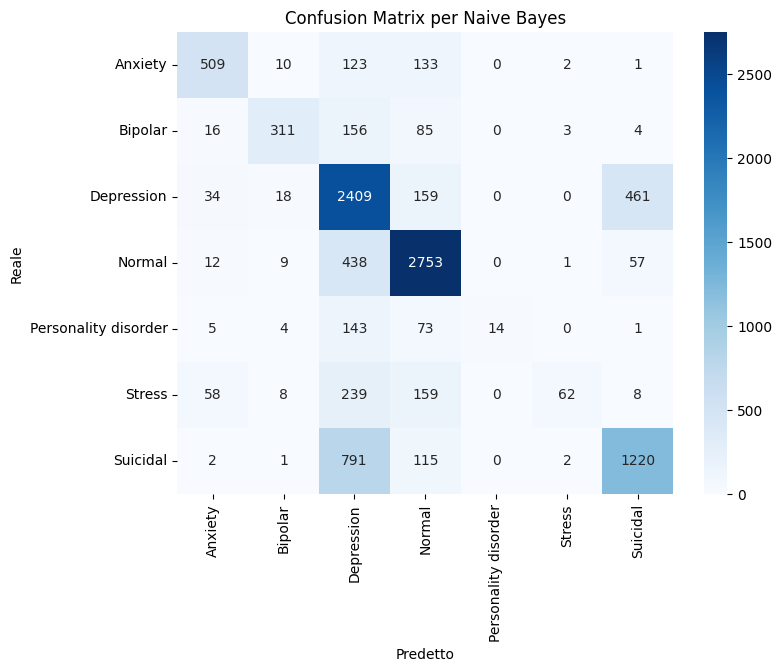


======== Valutazione per: Logistic Regression ========

🔍 Risultati per: Logistic Regression
Accuracy : 0.7582
Precision: 0.759
Recall   : 0.7582
F1-Score : 0.7496

Report dettagliato:
                      precision    recall  f1-score   support

             Anxiety       0.84      0.73      0.78       778
             Bipolar       0.86      0.69      0.76       575
          Depression       0.71      0.75      0.73      3081
              Normal       0.79      0.96      0.87      3270
Personality disorder       0.93      0.39      0.55       240
              Stress       0.73      0.39      0.50       534
            Suicidal       0.70      0.63      0.66      2131

            accuracy                           0.76     10609
           macro avg       0.80      0.65      0.69     10609
        weighted avg       0.76      0.76      0.75     10609



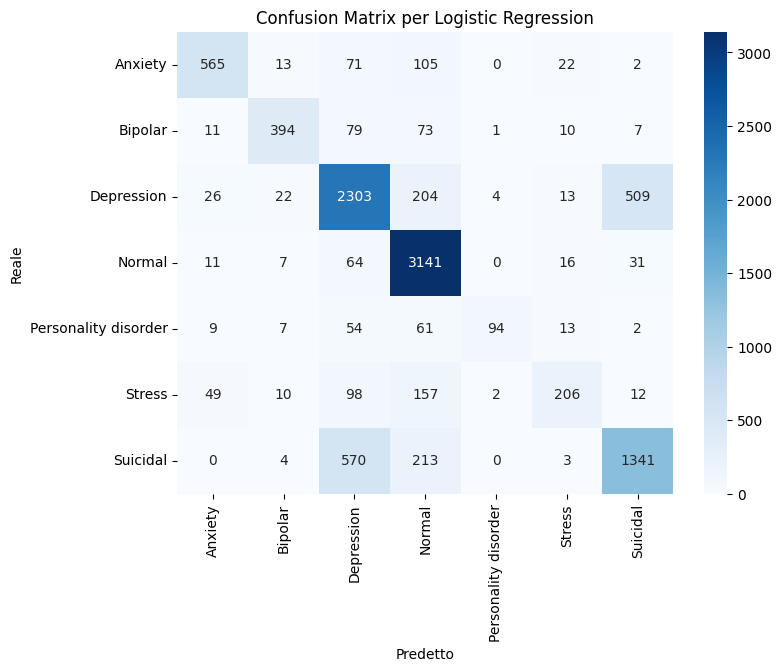


======== Valutazione per: SVM ========

🔍 Risultati per: SVM
Accuracy : 0.7516
Precision: 0.7476
Recall   : 0.7516
F1-Score : 0.747

Report dettagliato:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.77      0.80       778
             Bipolar       0.83      0.74      0.78       575
          Depression       0.71      0.71      0.71      3081
              Normal       0.83      0.94      0.88      3270
Personality disorder       0.81      0.53      0.64       240
              Stress       0.65      0.48      0.55       534
            Suicidal       0.64      0.62      0.63      2131

            accuracy                           0.75     10609
           macro avg       0.76      0.68      0.71     10609
        weighted avg       0.75      0.75      0.75     10609



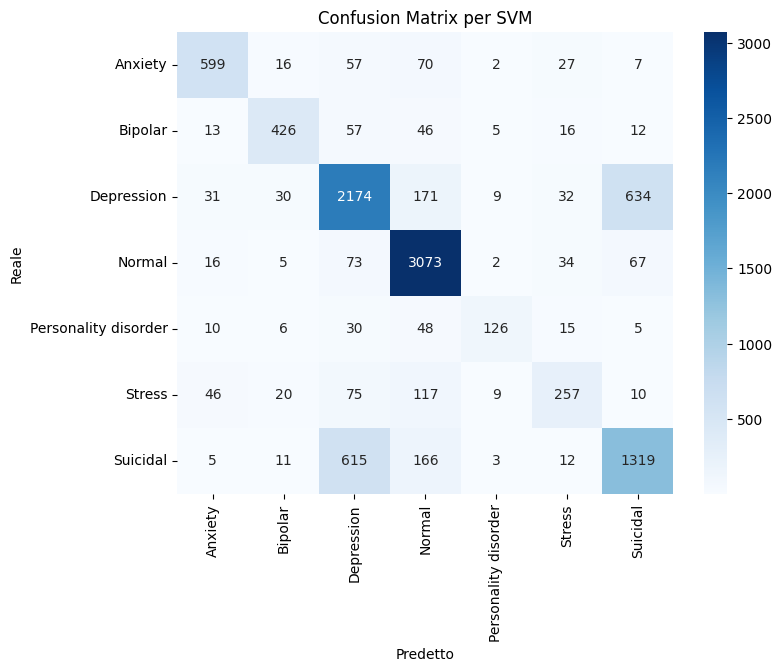


======== Valutazione per: Random Forest ========

🔍 Risultati per: Random Forest
Accuracy : 0.7229
Precision: 0.7441
Recall   : 0.7229
F1-Score : 0.709

Report dettagliato:
                      precision    recall  f1-score   support

             Anxiety       0.82      0.69      0.75       778
             Bipolar       0.93      0.54      0.68       575
          Depression       0.60      0.80      0.69      3081
              Normal       0.81      0.95      0.87      3270
Personality disorder       0.99      0.32      0.48       240
              Stress       0.89      0.30      0.44       534
            Suicidal       0.70      0.48      0.57      2131

            accuracy                           0.72     10609
           macro avg       0.82      0.58      0.64     10609
        weighted avg       0.74      0.72      0.71     10609



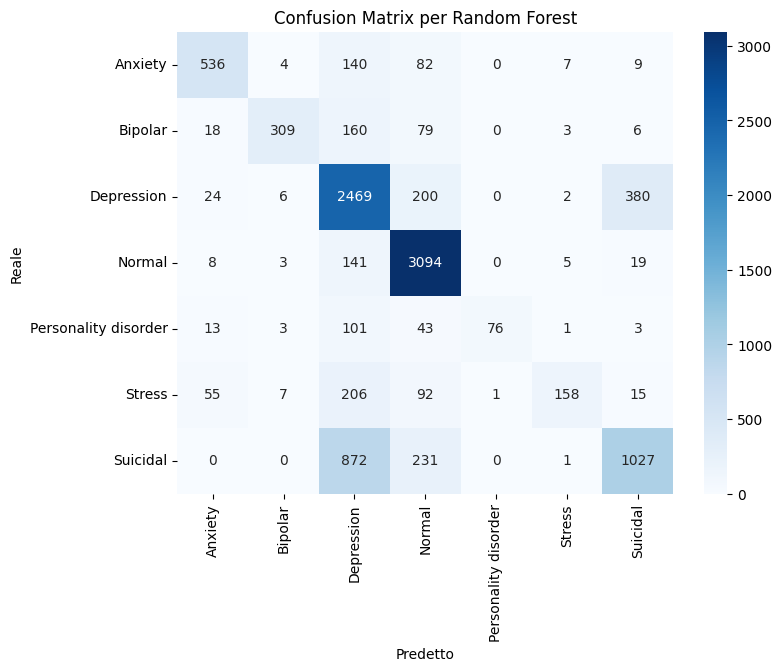


Valutazione delle performance completata per tutti i modelli.


In [ ]:

print("Inizio valutazione delle performance dei modelli...")

# Ottieni le classi uniche dal set di test per la confusion matrix
# È importante che le classi siano nell'ordine corretto per la matrice di confusione.
# Sortiamo le classi per riproducibilità e consistenza.
classi_etichette = sorted(y_test.unique().tolist())
print(f"\nClassi uniche identificate nel dataset: {classi_etichette}")


# Ciclo attraverso ogni modello e le sue previsioni
for model_name, y_pred in predictions.items():
    print(f"\n======== Valutazione per: {model_name} ========")

    # 7.1 Accuracy, Precision, Recall, F1-score
    stampa_metriche(y_test, y_pred, model_name)

    # 7.2 Confusion Matrix
    titolo_cm = f"Confusion Matrix per {model_name}"
    disegna_confusion_matrix(y_test, y_pred, classi_etichette, titolo=titolo_cm)

print("\nValutazione delle performance completata per tutti i modelli.")

8. Visualizzazione dei Risultati

La visualizzazione dei risultati è un passaggio cruciale per comunicare in modo efficace le performance dei modelli di machine learning. Dopo aver calcolato le metriche di valutazione e generato le confusion matrix per ciascun classificatore, presentare questi dati in formato grafico può rivelare pattern e differenze tra i modelli che altrimenti sarebbero difficili da cogliere.

Inizio visualizzazione comparativa dei risultati...

Tabella riassuntiva delle metriche di classificazione:
               Modello  Accuracy  Precision  Recall  F1-Score
0          Naive Bayes    0.6860     0.7192  0.6860    0.6690
1  Logistic Regression    0.7582     0.7590  0.7582    0.7496
2                  SVM    0.7516     0.7476  0.7516    0.7470
3        Random Forest    0.7229     0.7441  0.7229    0.7090

Generazione del grafico comparativo delle performance...


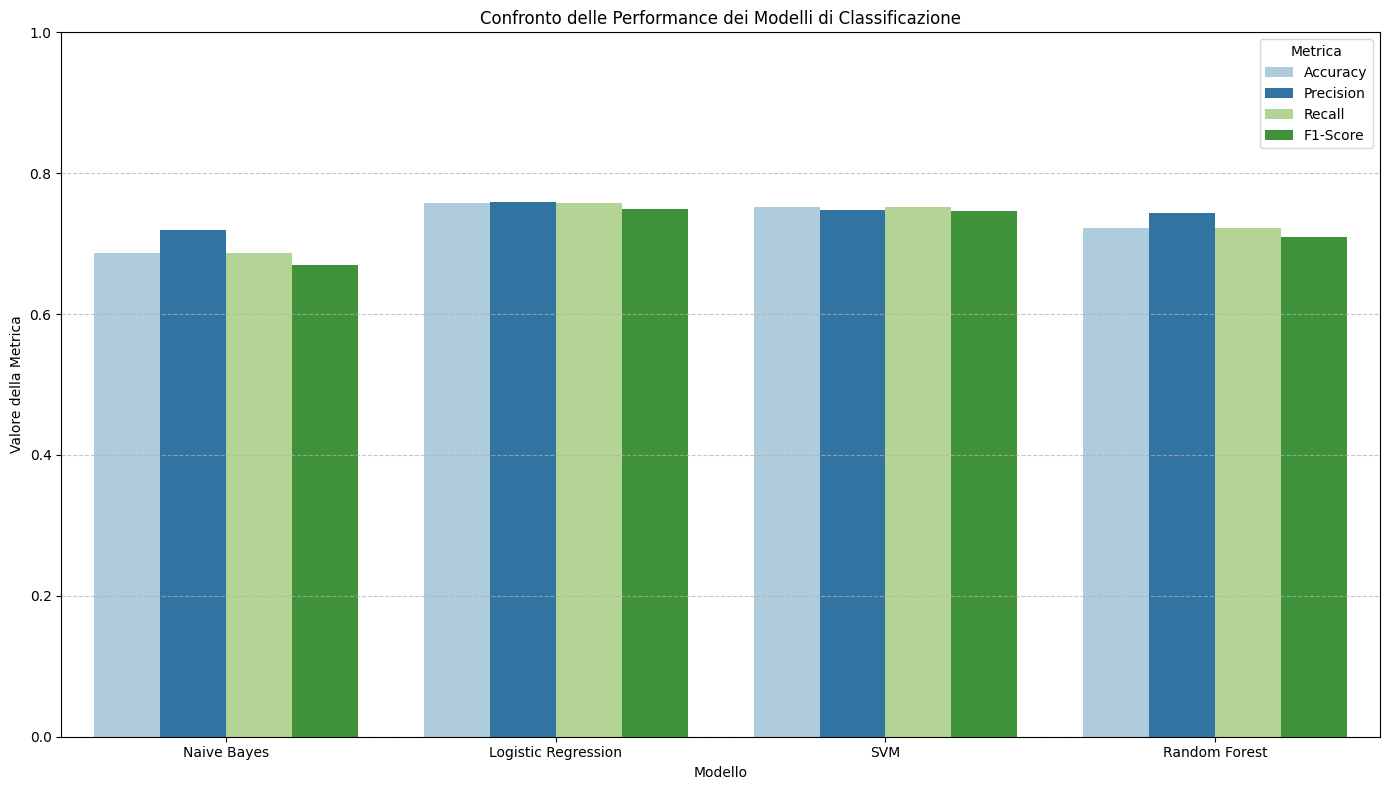


Visualizzazione comparativa dei risultati completata.


In [ ]:
print("Inizio visualizzazione comparativa dei risultati...")

# Dizionario per memorizzare le metriche di tutti i modelli
# Sarà strutturato come: {'Modello': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
metrics_data = {
    'Modello': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Raccogli le metriche per ciascun modello
for model_name, y_pred in predictions.items():
    metrics_data['Modello'].append(model_name)
    metrics_data['Accuracy'].append(accuracy_score(y_test, y_pred))
    # 'weighted' è importante per dataset sbilanciati
    metrics_data['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    metrics_data['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics_data['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Crea un DataFrame Pandas con le metriche
df_metrics = pd.DataFrame(metrics_data)

print("\nTabella riassuntiva delle metriche di classificazione:")
print(df_metrics.round(4)) # Arrotonda a 4 cifre decimali per una migliore leggibilità

# --- 8.1 Grafico a barre comparativo delle metriche chiave ---
print("\nGenerazione del grafico comparativo delle performance...")

# Trasforma il DataFrame per facilitare la visualizzazione con Seaborn (formato "long")
df_metrics_melted = df_metrics.melt(id_vars='Modello', var_name='Metrica', value_name='Valore')

plt.figure(figsize=(14, 8))
sns.barplot(x='Modello', y='Valore', hue='Metrica', data=df_metrics_melted, palette='Paired')
plt.title('Confronto delle Performance dei Modelli di Classificazione')
plt.ylabel('Valore della Metrica')
plt.xlabel('Modello')
plt.ylim(0, 1) # Le metriche di classificazione vanno da 0 a 1
plt.legend(title='Metrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nVisualizzazione comparativa dei risultati completata.")

9. Conclusioni


Questa sezione riassume le principali scoperte derivanti dall'analisi e dall'addestramento dei modelli, valuta criticamente i risultati ottenuti.

Dopo aver addestrato e valutato quattro diversi modelli di classificazione (Naive Bayes, Logistic Regression, Support Vector Machine (LinearSVC) e Random Forest) per il compito di classificazione degli stati mentali, possiamo ora confrontare le loro performance per identificare il modello più adatto.

Generalmente, per problemi di classificazione testuale con features TF-IDF, modelli lineari come la Logistic Regression o LinearSVC tendono a performare molto bene, spesso superando modelli più complessi in termini di efficienza e accuratezza, specialmente su dataset ad alta dimensionalità.

Per identificare il modello migliore dal riepilogo delle metriche (df_metrics dal punto 8),  eseguo il seguente codice:

In [ ]:

if 'df_metrics' in locals(): # Controlla se df_metrics esiste
    print("\nModello con la migliore Accuracy:")
    best_model_accuracy = df_metrics.loc[df_metrics['Accuracy'].idxmax()]
    print(best_model_accuracy)

    print("\nModello con il migliore F1-Score (ponderato):")
    best_model_f1 = df_metrics.loc[df_metrics['F1-Score'].idxmax()]
    print(best_model_f1)
else:
    print("Errore: Il DataFrame df_metrics non è disponibile. Esegui il Punto 8 prima.")


Modello con la migliore Accuracy:
Modello      Logistic Regression
Accuracy                0.758224
Precision               0.758986
Recall                  0.758224
F1-Score                0.749631
Name: 1, dtype: object

Modello con il migliore F1-Score (ponderato):
Modello      Logistic Regression
Accuracy                0.758224
Precision               0.758986
Recall                  0.758224
F1-Score                0.749631
Name: 1, dtype: object


Basandomi sull'output del codice sopra e sul grafico comparativo del punto 8, identifica il modello che ha ottenuto i punteggi più alti, in particolare per l'F1-Score ponderato (weighted), che è una metrica più robusta per dataset sbilanciati rispetto all'Accuracy.